<h1><Center>Convolutional Neural Network</Center></h1>

# **Imports**

## Libraries
- Import all neccessary libraries needed for the code to work.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Dropout, Flatten, MaxPooling2D, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter


# ignore warnings
import pickle
import warnings
warnings.filterwarnings("ignore")

## Import the images using PIL import Image
- PIL allows easy loading of images.
- provides a wide range of functions for manipulating images, such as cropping, rotating, resizing, etc.
- Can be used to do basic analysis on images such as image properties and converting to grayscale.

In [2]:
def get_images(base_folder):
    images = [] 
    labels = []
    for folder_name in os.listdir(base_folder):
        label = folder_name
        folder_path = os.path.join(base_folder, folder_name)
        for file_name in os.listdir(folder_path):

            # Get path
            img_path = os.path.join(folder_path, file_name)
            
            # Open the image
            img = Image.open(img_path)

            # Convert RGB images to grayscale
            img = img.convert('L')
            
            # Resize to 131x131
            img = img.resize((131, 131))
            img_array = np.array(img)

            # Check if the images are not empty
            if img_array.size > 0:  
                images.append(img_array) 
                labels.append(label)
    
    return images, labels

# training images and labels
X_train, y_train_labels = get_images('Dataset for CA1 part A - AY2425S1/train')

# test images and labels
X_test, y_test_labels = get_images('Dataset for CA1 part A - AY2425S1/test')

# validation images and labels
X_validation, y_validation_labels = get_images('Dataset for CA1 part A - AY2425S1/validation')

## Visualising some of the images
- After grayscale and resizing

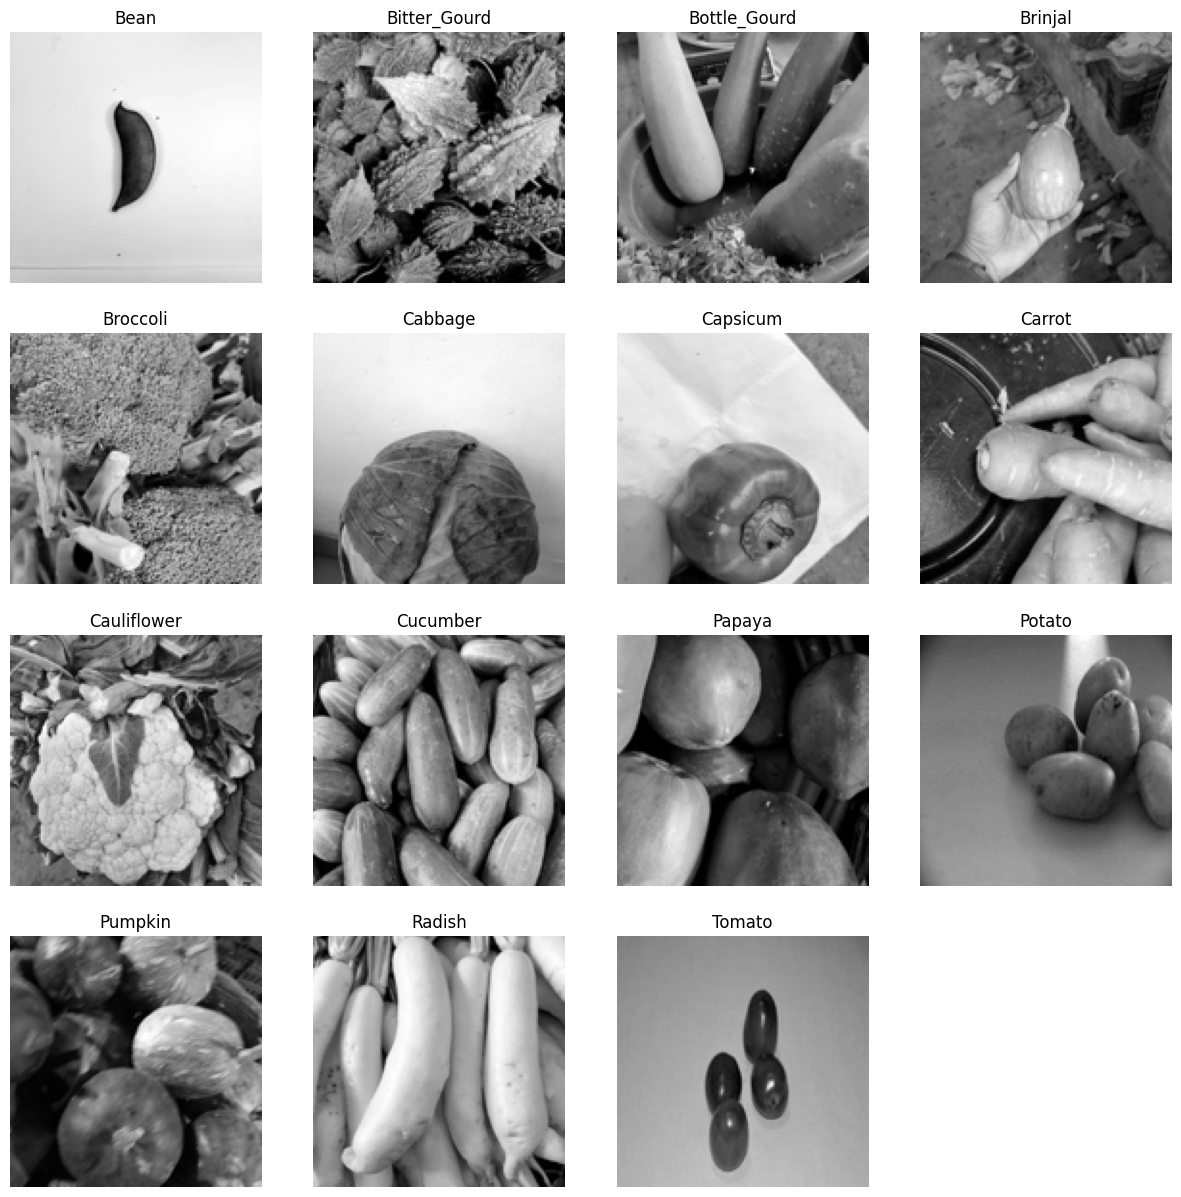

In [3]:
def show_one_image_per_label(images, labels):
    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    num_cols = 4
    num_rows = num_labels // num_cols + (1 if num_labels % num_cols != 0 else 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, label in enumerate(unique_labels):
        img_index = labels.index(label)
        img = images[img_index]
        row = i // num_cols
        col = i % num_cols
        if num_rows > 1:
            axes[row, col].imshow(img, cmap='gray')
            axes[row, col].set_title(label)
            axes[row, col].axis('off')
        else:
            axes[col].imshow(img, cmap='gray')
            axes[col].set_title(label)
            axes[col].axis('off')

    # Remove the last empty subplot if necessary
    if num_labels % num_cols != 0:
        empty_row = num_labels // num_cols
        empty_col = num_labels % num_cols
        if num_rows > 1:
            axes[empty_row, empty_col].axis('off')
        else:
            axes[empty_col].axis('off')

    plt.show()

# Show one image per label for training set
show_one_image_per_label(X_train, y_train_labels)

# **Data Preparation**

## Normalization

- Convert lists to numpy arrays.
- Standardize the pixel values of the images to have a mean of 0 and a standard deviation of 1 to stabilize the training process.
- Leads to faster convergence during training and prevents any one feature from dominating the learning process.

In [4]:
# Convert list to numpy array and normalize pixel values of images 131x131
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0
X_validation = np.array(X_validation, dtype=np.float32) / 255.0

## One-Hot Encoding

- Converts categorical labels into a binary matrix representation.
- Ensures that the model treats each class as mutually exclusive, thus preventing it from assuming any ordinal relationship between the classes.

In [5]:
# # METHOD 1: Using Label Binarizer to directly binarize the labels
# from sklearn.preprocessing import LabelBinarizer

# # Initialize LabelBinarizer
# label_binarizer = LabelBinarizer()

# # Fit and transform labels for training data
# y_train_one_hot = label_binarizer.fit_transform(y_train_labels)

# # Transform labels for testing and validation data
# y_test_one_hot = label_binarizer.transform(y_test_labels)
# y_validation_one_hot = label_binarizer.transform(y_validation_labels)



# METHOD 2: Use label Encoder first to encode the labels as integers 
# then use to_categorical to convert into one-hot encoded vectors
encoder = LabelEncoder()

# Convert string labels to One-Hot Encoding
y_train_int = encoder.fit_transform(y_train_labels)
y_test_int = encoder.transform(y_test_labels) 
y_validation_int = encoder.transform(y_validation_labels)

# Convert integer encoded labels to one-hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train_int)
y_test = tf.keras.utils.to_categorical(y_test_int)
y_validation = tf.keras.utils.to_categorical(y_validation_int)

## Data Visualization from original Data
Counting number of images in each label
- train: mixed number
- test: 200 each
- validation: 200 each

Bar graph 
- To visualize the distribution of label within each dataset.
-  helps to understand if the dataset is balanced or skewed towards certain classes.

Training Label Counts: Counter({'Tomato': 955, 'Brinjal': 868, 'Pumpkin': 814, 'Cucumber': 812, 'Bean': 780, 'Broccoli': 750, 'Bitter_Gourd': 720, 'Cauliflower': 587, 'Papaya': 566, 'Cabbage': 503, 'Bottle_Gourd': 441, 'Potato': 377, 'Capsicum': 351, 'Carrot': 256, 'Radish': 248}) 

Test Label Counts: Counter({'Bean': 200, 'Bitter_Gourd': 200, 'Bottle_Gourd': 200, 'Brinjal': 200, 'Broccoli': 200, 'Cabbage': 200, 'Capsicum': 200, 'Carrot': 200, 'Cauliflower': 200, 'Cucumber': 200, 'Papaya': 200, 'Potato': 200, 'Pumpkin': 200, 'Radish': 200, 'Tomato': 200}) 

Validation Label Counts: Counter({'Bean': 200, 'Bitter_Gourd': 200, 'Bottle_Gourd': 200, 'Brinjal': 200, 'Broccoli': 200, 'Cabbage': 200, 'Capsicum': 200, 'Carrot': 200, 'Cauliflower': 200, 'Cucumber': 200, 'Papaya': 200, 'Potato': 200, 'Pumpkin': 200, 'Radish': 200, 'Tomato': 200})


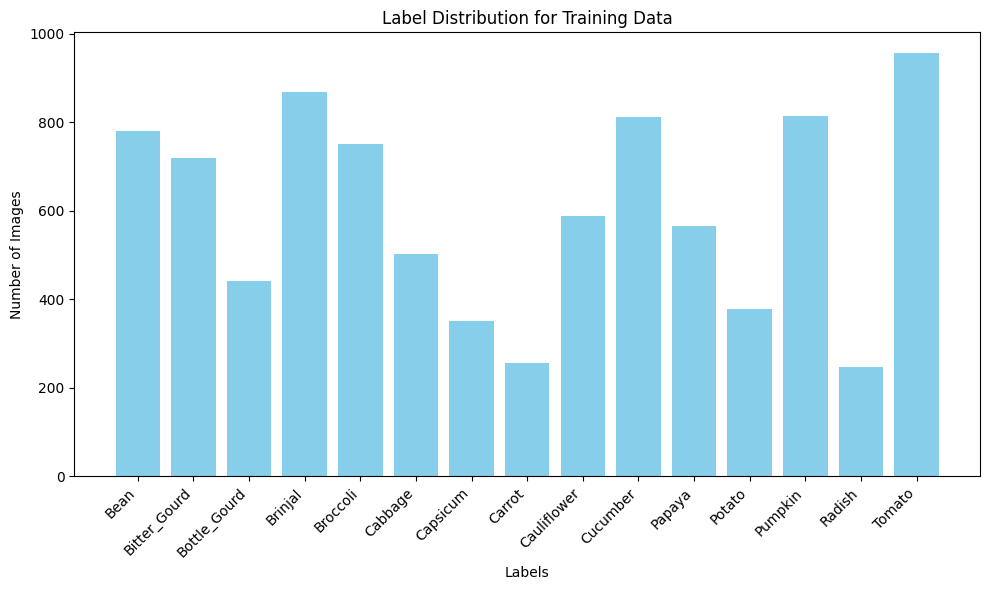

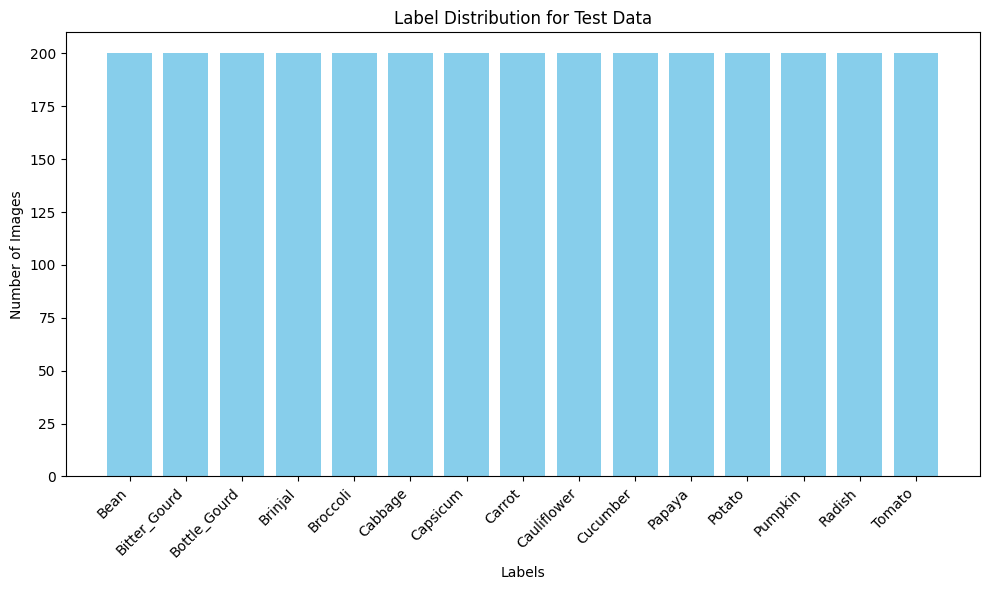

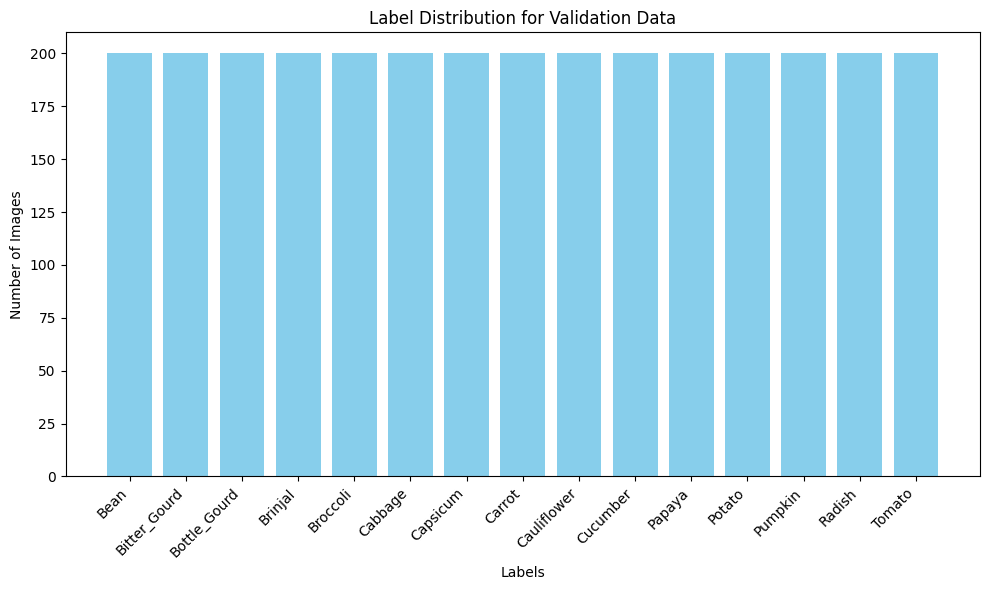

In [5]:
# Count the number of class in each dataset
label_counts_train = Counter(y_train_labels)
label_counts_test = Counter(y_test_labels)
label_counts_validation = Counter(y_validation_labels)

# Display the counts
print("Training Label Counts:", label_counts_train,'\n')
print("Test Label Counts:", label_counts_test,'\n')
print("Validation Label Counts:", label_counts_validation)

# Bar graph
def plot_label_distribution(label_counts, dataset_name):
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Labels')
    plt.ylabel('Number of Images')
    plt.title(f'Label Distribution for {dataset_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot label distribution for training data
plot_label_distribution(label_counts_train, 'Training Data')

# Plot label distribution for test data
plot_label_distribution(label_counts_test, 'Test Data')

# Plot label distribution for validation data
plot_label_distribution(label_counts_validation, 'Validation Data')

## Data Augmentation
- From the data visualization, we know that there is a class imbalance due to the different number of vegetable images.
- Data augmentation is then used to artificially increase the size of the training dataset by applying various transformations.
- Some transformations include: Rotation, Translation, Shearing, Scaling, Flipping, Contrast adjustment, Brightness adjustment, Noise addition.
- We use a loop to find the class that does not reach our target number of images (1000). We then augment those images with different transformations to reach the target count.

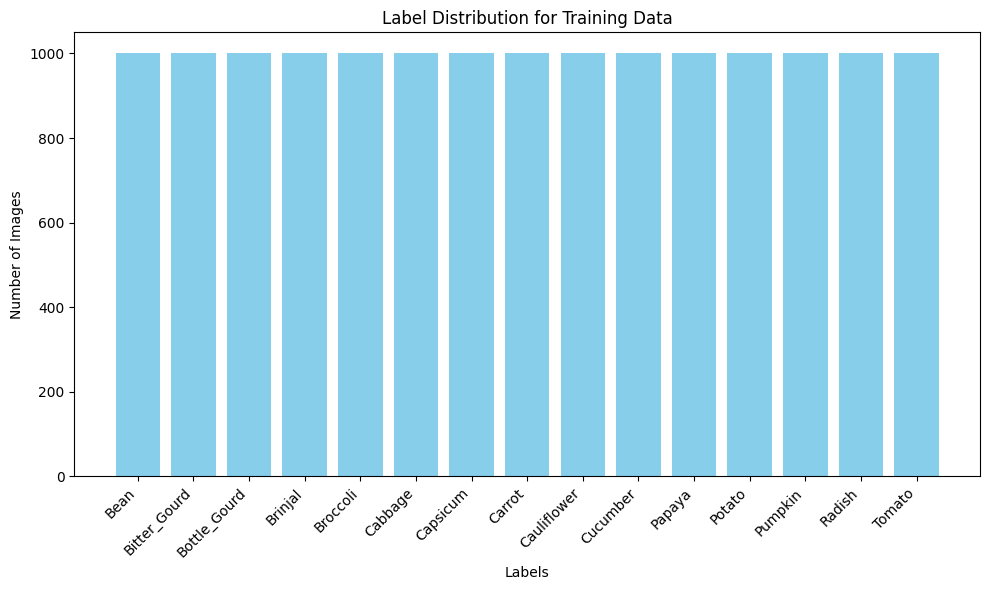

In [13]:
# Create another variable so it doesnt change the original y_train_labels
y_train_labels_augmentation = y_train_labels.copy()

# Function to augment the new images into the training data
def augment_images(X_train, y_train_labels_augmentation, batch_size, target_count):
    
    # Find the distribution of labels
    distribution = Counter(y_train_labels_augmentation)
    
    # Use ImageDataGenerator with different augmentation options
    data_gen = ImageDataGenerator(
        rotation_range=15,            # Rotate by up to 15 degrees
        width_shift_range=0.1,        # Shift horizontally by up to 10% of the width
        height_shift_range=0.1,       # Shift vertically by up to 10% of the height
        shear_range=0.1,              # Shear angle in radians
        zoom_range=0.1,               # Zoom range [1-zoom_range, 1+zoom_range]
        horizontal_flip=True,         # Flip horizontally
        fill_mode='nearest',          # Fill mode for points outside the input boundaries
        brightness_range=[0.8, 1.2]   # Increases and decreases the brightness
    )

    # Add augment to classes with fewer image than the 1000
    for class_label, count in distribution.items():
        if count < target_count:
            # Calculate number of images needed to augment
            num_additional = target_count - count

            # Get indices of all occurrences of this class
            class_indices = np.where(np.array(y_train_labels) == class_label)[0]

            # Augment images until target count is reached
            for i in range(num_additional):
                # Choose random images from this class
                sample_indices = np.random.choice(class_indices, size=min(batch_size, num_additional), replace=False)
                sample_images = X_train[sample_indices]

                # Before augment: Expand image to include channel dimension
                sample_images = np.expand_dims(sample_images, axis=-1)  

                # Generate augmented images
                augmented_images = next(data_gen.flow(sample_images, batch_size=batch_size))

                # After augment: Remove the image channel dimension for grayscale
                augmented_images = np.squeeze(augmented_images, axis=-1)

                # Append augmented images and labels to the training set
                X_train = np.concatenate((X_train, augmented_images))
                y_train_labels_augmentation.extend([class_label] * augmented_images.shape[0])
                num_additional -= augmented_images.shape[0]

    # Reshape X_train
    X_train = X_train.reshape((-1, 131, 131, 1))

    return X_train, y_train_labels_augmentation

# Calling the function for 131x131
X_train_augmented, y_train_augmented = augment_images(X_train, y_train_labels_augmentation, batch_size=32, target_count=1000)

# Changing y_train_augmented back into encoded
label_binarizer = LabelBinarizer()
# Fit and transform the labels
y_train_augmented = label_binarizer.fit_transform(y_train_augmented)


# Visualizing the new distribution of the labels
label_counts_augmented = Counter(y_train_labels_augmentation)
plot_label_distribution(label_counts_augmented, 'Training Data')

# **CNN Model**

## Simple CNN model before Data Augmentation

### Modelling
- 3 convolutional layers
- 'relu' as the activation function because it introduces sparsity in the network which can help reduce the computational load and overfitting by providing a better selective representation of the images.
- 'softmax' as the output activation function because it uses probability interpretation to convert the raw scores produced by the neural network into probabilities to find out what label the input belongs to.


Reference:
1. https://www.analyticsvidhya.com/blog/2021/04/introduction-to-softmax-for-neural
2. https://medium.com/@sreeku.ralla/activation-functions-relu-vs-leaky-relu-b8272dc0b1be

In [188]:
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=15, batch_size=64, verbose=1) 

Epoch 1/15
142/142 [==============================] - 4s 28ms/step - loss: 2.4497 - accuracy: 0.1613 - val_loss: 2.2696 - val_accuracy: 0.2807
Epoch 2/15
142/142 [==============================] - 4s 26ms/step - loss: 1.7793 - accuracy: 0.4204 - val_loss: 1.8297 - val_accuracy: 0.4050
Epoch 3/15
142/142 [==============================] - 4s 26ms/step - loss: 1.3423 - accuracy: 0.5716 - val_loss: 1.3792 - val_accuracy: 0.5377
Epoch 4/15
142/142 [==============================] - 4s 26ms/step - loss: 1.0863 - accuracy: 0.6554 - val_loss: 1.2355 - val_accuracy: 0.5963
Epoch 5/15
142/142 [==============================] - 4s 26ms/step - loss: 0.8757 - accuracy: 0.7174 - val_loss: 0.7756 - val_accuracy: 0.7527
Epoch 6/15
142/142 [==============================] - 4s 26ms/step - loss: 0.7565 - accuracy: 0.7613 - val_loss: 0.9767 - val_accuracy: 0.6777
Epoch 7/15
142/142 [==============================] - 4s 26ms/step - loss: 0.5891 - accuracy: 0.8096 - val_loss: 0.7757 - val_accuracy: 0.7520

### Evaluation

In [189]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_115"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_351 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 max_pooling2d_144 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_288 (Dropout)       (None, 42, 42, 128)       0         
                                                                 
 conv2d_352 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 max_pooling2d_145 (MaxPooli  (None, 13, 13, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_289 (Dropout)       (None, 13, 13, 128)    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.343474805355072
Validation Accuracy: 0.8989999890327454


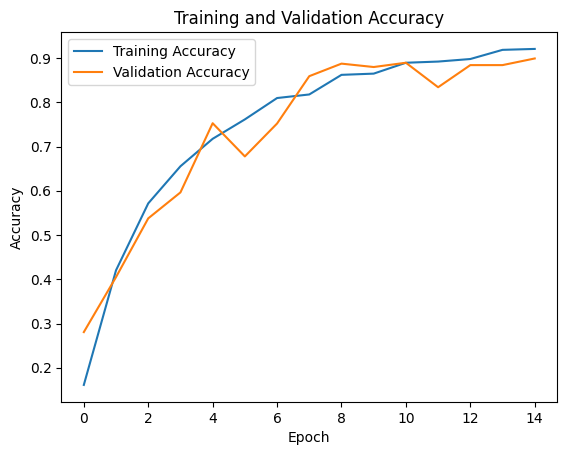

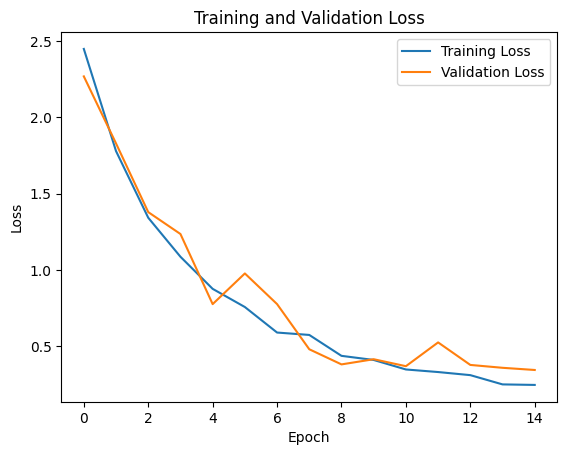

In [190]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 4ms/step


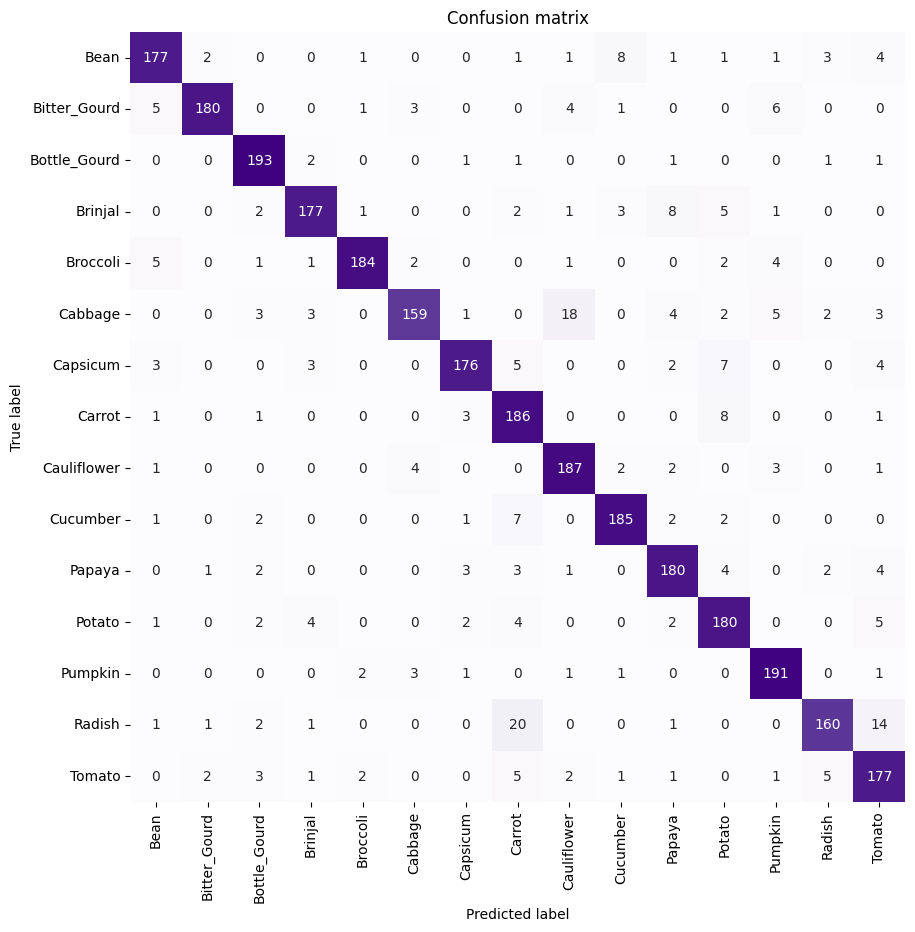

Classification Report:
               precision    recall  f1-score   support

        Bean       0.91      0.89      0.90       200
Bitter_Gourd       0.97      0.90      0.93       200
Bottle_Gourd       0.91      0.96      0.94       200
     Brinjal       0.92      0.89      0.90       200
    Broccoli       0.96      0.92      0.94       200
     Cabbage       0.93      0.80      0.86       200
    Capsicum       0.94      0.88      0.91       200
      Carrot       0.79      0.93      0.86       200
 Cauliflower       0.87      0.94      0.90       200
    Cucumber       0.92      0.93      0.92       200
      Papaya       0.88      0.90      0.89       200
      Potato       0.85      0.90      0.88       200
     Pumpkin       0.90      0.95      0.93       200
      Radish       0.92      0.80      0.86       200
      Tomato       0.82      0.89      0.85       200

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
we

In [191]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Simple CNN model after Data Augmentation

### Modelling

Explanation
- Increased dataset size after Data Augmentation. Each label contains 200 images of each vegetable.
- This helps to prevent bias image training and regularize the images so that the model will learn more generalizable features.

In [192]:
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train_augmented, y_train_augmented, validation_data=(X_validation, y_validation),
          epochs=15, batch_size=64, verbose=1) 

Epoch 1/15
235/235 [==============================] - 6s 25ms/step - loss: 2.4900 - accuracy: 0.1485 - val_loss: 2.0952 - val_accuracy: 0.3100
Epoch 2/15
235/235 [==============================] - 6s 24ms/step - loss: 2.0570 - accuracy: 0.3135 - val_loss: 1.6880 - val_accuracy: 0.4577
Epoch 3/15
235/235 [==============================] - 6s 24ms/step - loss: 1.7695 - accuracy: 0.4127 - val_loss: 1.3926 - val_accuracy: 0.5457
Epoch 4/15
235/235 [==============================] - 6s 26ms/step - loss: 1.5883 - accuracy: 0.4706 - val_loss: 0.7938 - val_accuracy: 0.7517
Epoch 5/15
235/235 [==============================] - 6s 26ms/step - loss: 1.4471 - accuracy: 0.5184 - val_loss: 0.6867 - val_accuracy: 0.7843
Epoch 6/15
235/235 [==============================] - 6s 25ms/step - loss: 1.3466 - accuracy: 0.5418 - val_loss: 0.5220 - val_accuracy: 0.8407
Epoch 7/15
235/235 [==============================] - 6s 26ms/step - loss: 1.2962 - accuracy: 0.5619 - val_loss: 0.5994 - val_accuracy: 0.8063

### Evaluation

In [193]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_354 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 max_pooling2d_147 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_291 (Dropout)       (None, 42, 42, 128)       0         
                                                                 
 conv2d_355 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 max_pooling2d_148 (MaxPooli  (None, 13, 13, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_292 (Dropout)       (None, 13, 13, 128)    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.3418194055557251
Validation Accuracy: 0.9020000100135803


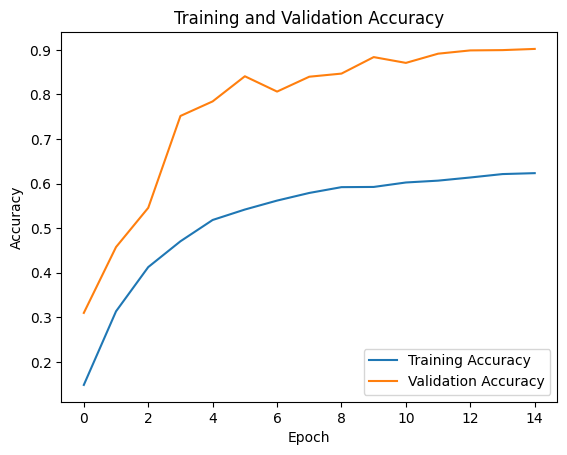

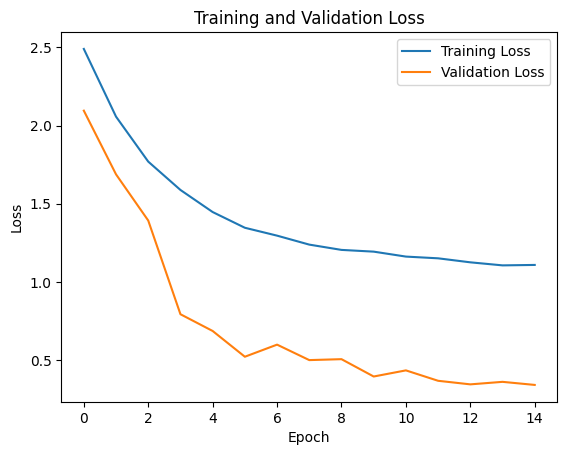

In [194]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 4ms/step


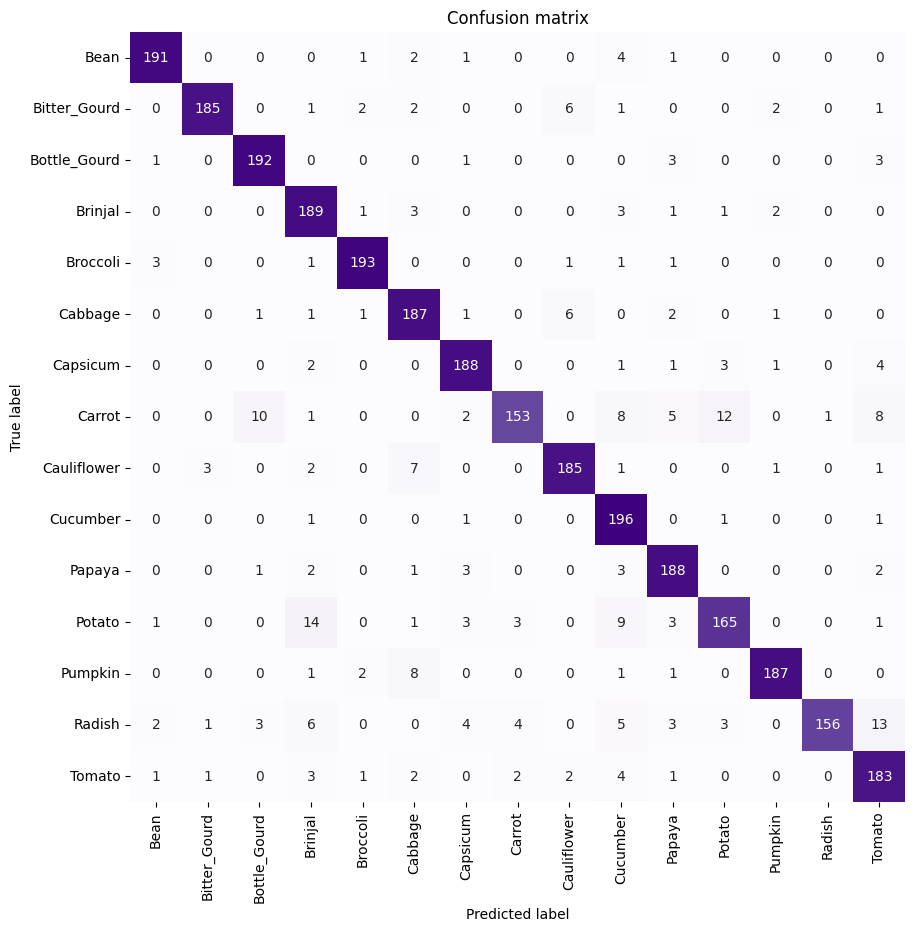

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.97      0.93      0.95       200
           2       0.93      0.96      0.94       200
           3       0.84      0.94      0.89       200
           4       0.96      0.96      0.96       200
           5       0.88      0.94      0.91       200
           6       0.92      0.94      0.93       200
           7       0.94      0.77      0.85       200
           8       0.93      0.93      0.93       200
           9       0.83      0.98      0.90       200
          10       0.90      0.94      0.92       200
          11       0.89      0.82      0.86       200
          12       0.96      0.94      0.95       200
          13       0.99      0.78      0.87       200
          14       0.84      0.92      0.88       200

    accuracy                           0.91      3000
   macro avg       0.92      0.91      0.91      3000
we

In [195]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying to add Batch normalization

### Modelling

Batch Normalization Explanation
- It speeds up learning as it reduces internal covariate shifts which helps the model train faster.
- It adds a little noise to the model and therefore, regularization techniques such as dropout is not neccessary.
- It helps to us much larger learning rates, hence speeding up the training process.

Reference: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/

In [279]:
from tensorflow.keras.layers import BatchNormalization

# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=15, batch_size=64, verbose=1) 

Epoch 1/15
142/142 [==============================] - 7s 43ms/step - loss: 1.4931 - accuracy: 0.5459 - val_loss: 6.3976 - val_accuracy: 0.0840
Epoch 2/15
142/142 [==============================] - 6s 41ms/step - loss: 0.6694 - accuracy: 0.7931 - val_loss: 8.0113 - val_accuracy: 0.0800
Epoch 3/15
142/142 [==============================] - 6s 41ms/step - loss: 0.4117 - accuracy: 0.8748 - val_loss: 5.5302 - val_accuracy: 0.1883
Epoch 4/15
142/142 [==============================] - 6s 40ms/step - loss: 0.2207 - accuracy: 0.9330 - val_loss: 3.0368 - val_accuracy: 0.3477
Epoch 5/15
142/142 [==============================] - 6s 41ms/step - loss: 0.1946 - accuracy: 0.9425 - val_loss: 1.4730 - val_accuracy: 0.6497
Epoch 6/15
142/142 [==============================] - 6s 41ms/step - loss: 0.1061 - accuracy: 0.9694 - val_loss: 1.1572 - val_accuracy: 0.7070
Epoch 7/15
142/142 [==============================] - 6s 41ms/step - loss: 0.1197 - accuracy: 0.9639 - val_loss: 6.2540 - val_accuracy: 0.2860

### Evaluation

In [280]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_420 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 batch_normalization_21 (Bat  (None, 128, 128, 128)    512       
 chNormalization)                                                
                                                                 
 max_pooling2d_186 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_421 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 batch_normalization_22 (Bat  (None, 39, 39, 128)      512       
 chNormalization)                                                
                                                    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.6566247940063477
Validation Accuracy: 0.8330000042915344


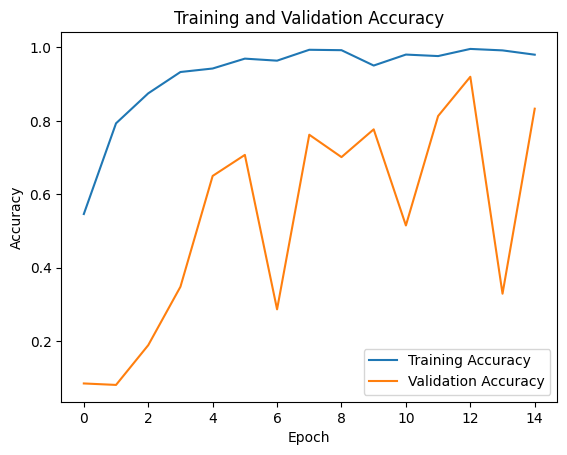

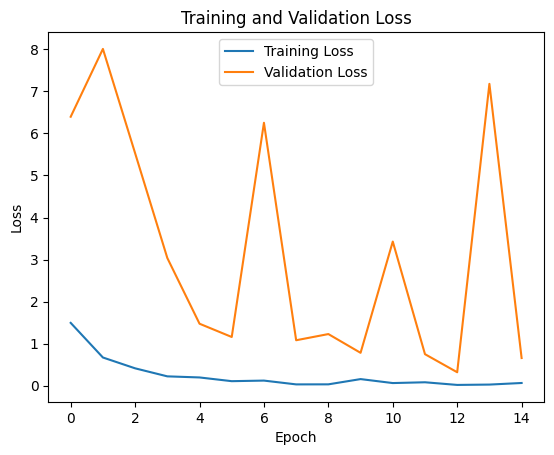

In [281]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 1s 5ms/step


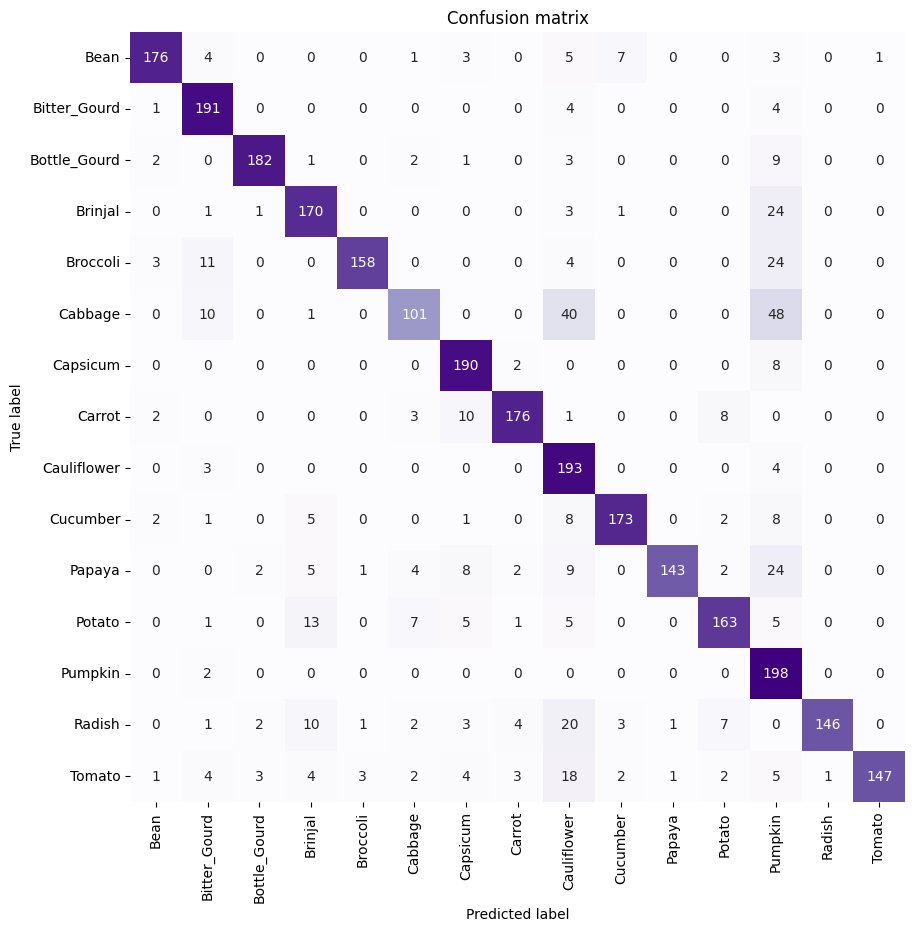

Classification Report:
               precision    recall  f1-score   support

        Bean       0.94      0.88      0.91       200
Bitter_Gourd       0.83      0.95      0.89       200
Bottle_Gourd       0.96      0.91      0.93       200
     Brinjal       0.81      0.85      0.83       200
    Broccoli       0.97      0.79      0.87       200
     Cabbage       0.83      0.51      0.63       200
    Capsicum       0.84      0.95      0.89       200
      Carrot       0.94      0.88      0.91       200
 Cauliflower       0.62      0.96      0.75       200
    Cucumber       0.93      0.86      0.90       200
      Papaya       0.99      0.71      0.83       200
      Potato       0.89      0.81      0.85       200
     Pumpkin       0.54      0.99      0.70       200
      Radish       0.99      0.73      0.84       200
      Tomato       0.99      0.73      0.84       200

    accuracy                           0.84      3000
   macro avg       0.87      0.84      0.84      3000
we

In [282]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying to add Earlystopping and Modelcheckpoint

### Modelling

Early Stopping Explanation
- It is important for situations to reduce overfitting and increase the model's performance on any general datasset.
- It takes less time compared to other regularisation models and its easy to implement.
- It calculates the loss to epoch and will stop when the loss starts to increase again.
- min_delta parameter allows you to set a threshold for the magnitude of change in the metric.
- patience parameter determines the number of epochs to wait before considering stopping.

Model Checkpoint Explanation
- Captures the weights of the model during training
- It automatically saves the model weights whenever the quantity is optimum when compared to last epoch/batch

Reference
1. https://www.geeksforgeeks.org/regularization-by-early-stopping/
2. https://medium.com/swlh/a-high-level-overview-of-keras-modelcheckpoint-callback-deae8099d786

In [266]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath='best_model_131.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=20, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint]) 

Epoch 1/20
142/142 [==============================] - 4s 27ms/step - loss: 2.5167 - accuracy: 0.1358 - val_loss: 2.3298 - val_accuracy: 0.1980
Epoch 2/20
142/142 [==============================] - 4s 26ms/step - loss: 1.9349 - accuracy: 0.3675 - val_loss: 1.8183 - val_accuracy: 0.3747
Epoch 3/20
142/142 [==============================] - 4s 26ms/step - loss: 1.4469 - accuracy: 0.5346 - val_loss: 1.4590 - val_accuracy: 0.5230
Epoch 4/20
142/142 [==============================] - 4s 26ms/step - loss: 1.0853 - accuracy: 0.6450 - val_loss: 0.9814 - val_accuracy: 0.6880
Epoch 5/20
142/142 [==============================] - 4s 26ms/step - loss: 0.8691 - accuracy: 0.7229 - val_loss: 0.7796 - val_accuracy: 0.7523
Epoch 6/20
142/142 [==============================] - 4s 26ms/step - loss: 0.6909 - accuracy: 0.7745 - val_loss: 0.6631 - val_accuracy: 0.7840
Epoch 7/20
142/142 [==============================] - 4s 27ms/step - loss: 0.5823 - accuracy: 0.8129 - val_loss: 0.5471 - val_accuracy: 0.8313

### Evaluation

In [267]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_408 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 max_pooling2d_177 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_321 (Dropout)       (None, 42, 42, 128)       0         
                                                                 
 conv2d_409 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 max_pooling2d_178 (MaxPooli  (None, 13, 13, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_322 (Dropout)       (None, 13, 13, 128)    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.27632156014442444
Validation Accuracy: 0.9236666560173035


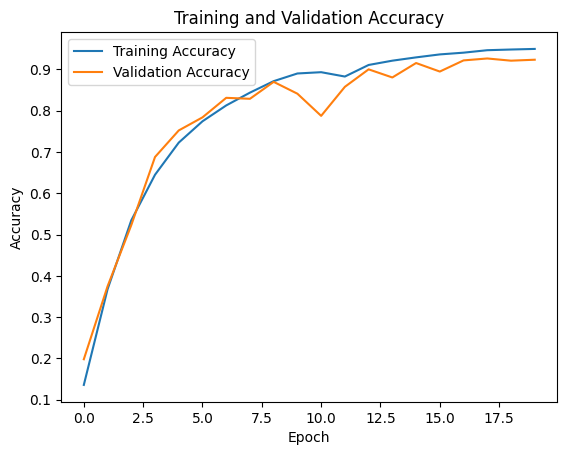

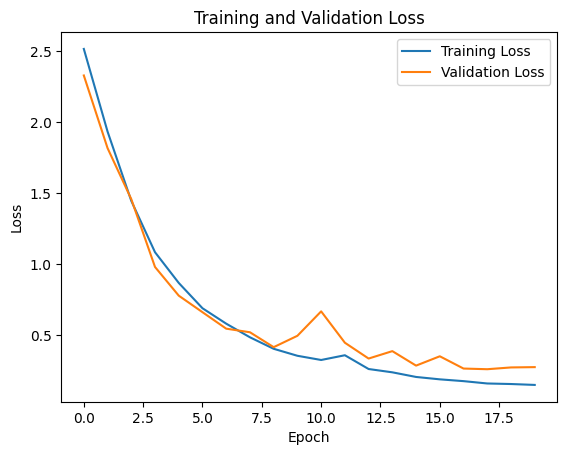

In [268]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 4ms/step


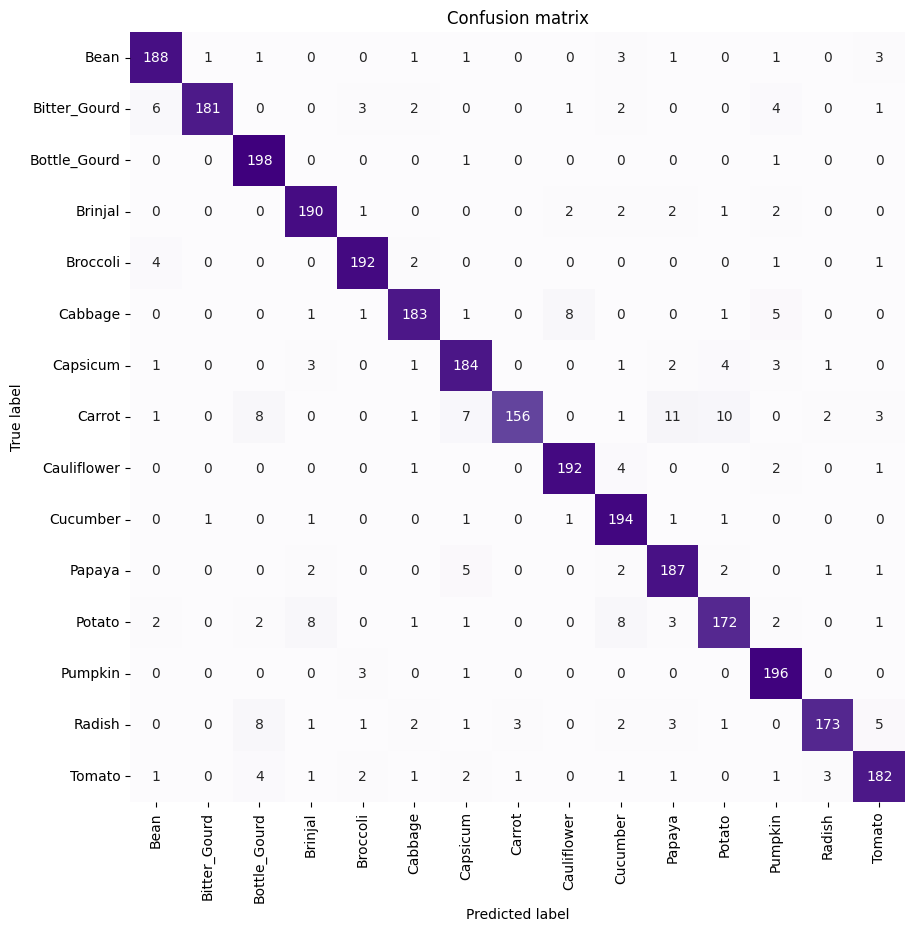

Classification Report:
               precision    recall  f1-score   support

        Bean       0.93      0.94      0.93       200
Bitter_Gourd       0.99      0.91      0.95       200
Bottle_Gourd       0.90      0.99      0.94       200
     Brinjal       0.92      0.95      0.93       200
    Broccoli       0.95      0.96      0.95       200
     Cabbage       0.94      0.92      0.93       200
    Capsicum       0.90      0.92      0.91       200
      Carrot       0.97      0.78      0.87       200
 Cauliflower       0.94      0.96      0.95       200
    Cucumber       0.88      0.97      0.92       200
      Papaya       0.89      0.94      0.91       200
      Potato       0.90      0.86      0.88       200
     Pumpkin       0.90      0.98      0.94       200
      Radish       0.96      0.86      0.91       200
      Tomato       0.92      0.91      0.91       200

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
we

In [269]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying AveragePooling2D instead of MaxPooling2D

### Modelling

Explanation
- The average value of all the pixels in the batch is selected.
- Compared to MaxPooling2D, AveragePooling2D is less sensitive to small variations and noise in the input data.
- Finding the average value of a group of pixels can help to capture the general presence of a feature in a larger region.

Reference: https://www.quora.com/What-is-the-benefit-of-using-average-pooling-rather-than-max-pooling

In [206]:
from keras.layers import AveragePooling2D
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=30, batch_size=64, verbose=1) 

Epoch 1/30
142/142 [==============================] - 4s 28ms/step - loss: 2.5339 - accuracy: 0.1618 - val_loss: 2.4750 - val_accuracy: 0.1737
Epoch 2/30
142/142 [==============================] - 4s 28ms/step - loss: 1.9976 - accuracy: 0.3552 - val_loss: 2.0424 - val_accuracy: 0.3547
Epoch 3/30
142/142 [==============================] - 4s 29ms/step - loss: 1.6963 - accuracy: 0.4524 - val_loss: 1.7859 - val_accuracy: 0.4353
Epoch 4/30
142/142 [==============================] - 4s 29ms/step - loss: 1.4903 - accuracy: 0.5153 - val_loss: 1.4144 - val_accuracy: 0.5390
Epoch 5/30
142/142 [==============================] - 4s 27ms/step - loss: 1.2904 - accuracy: 0.5872 - val_loss: 1.2777 - val_accuracy: 0.5900
Epoch 6/30
142/142 [==============================] - 4s 28ms/step - loss: 1.1668 - accuracy: 0.6284 - val_loss: 1.2002 - val_accuracy: 0.6093
Epoch 7/30
142/142 [==============================] - 4s 28ms/step - loss: 1.0442 - accuracy: 0.6695 - val_loss: 1.0996 - val_accuracy: 0.6563

### Evaluation

In [207]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_363 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 average_pooling2d_18 (Avera  (None, 42, 42, 128)      0         
 gePooling2D)                                                    
                                                                 
 dropout_297 (Dropout)       (None, 42, 42, 128)       0         
                                                                 
 conv2d_364 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 average_pooling2d_19 (Avera  (None, 13, 13, 128)      0         
 gePooling2D)                                                    
                                                                 
 dropout_298 (Dropout)       (None, 13, 13, 128)    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.4360201358795166
Validation Accuracy: 0.890999972820282


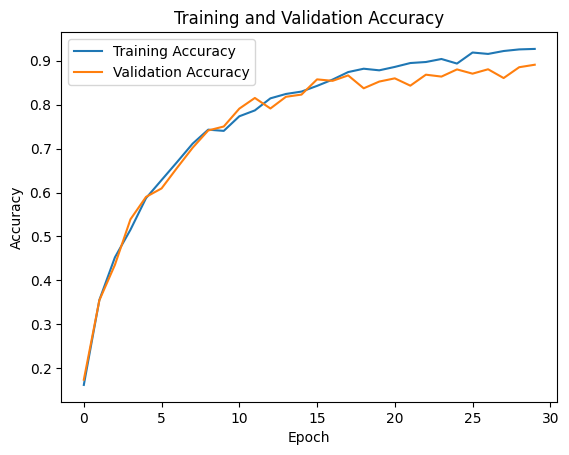

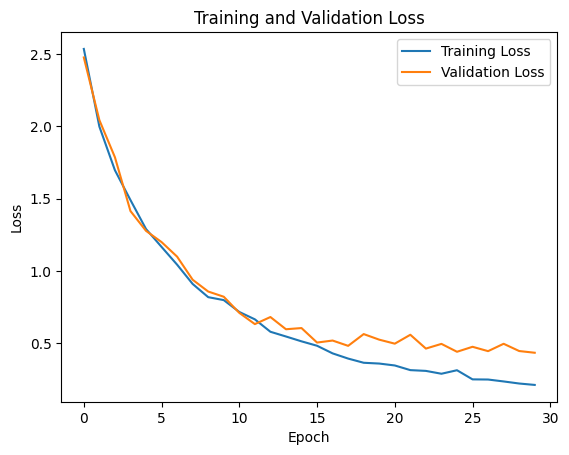

In [208]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 4ms/step


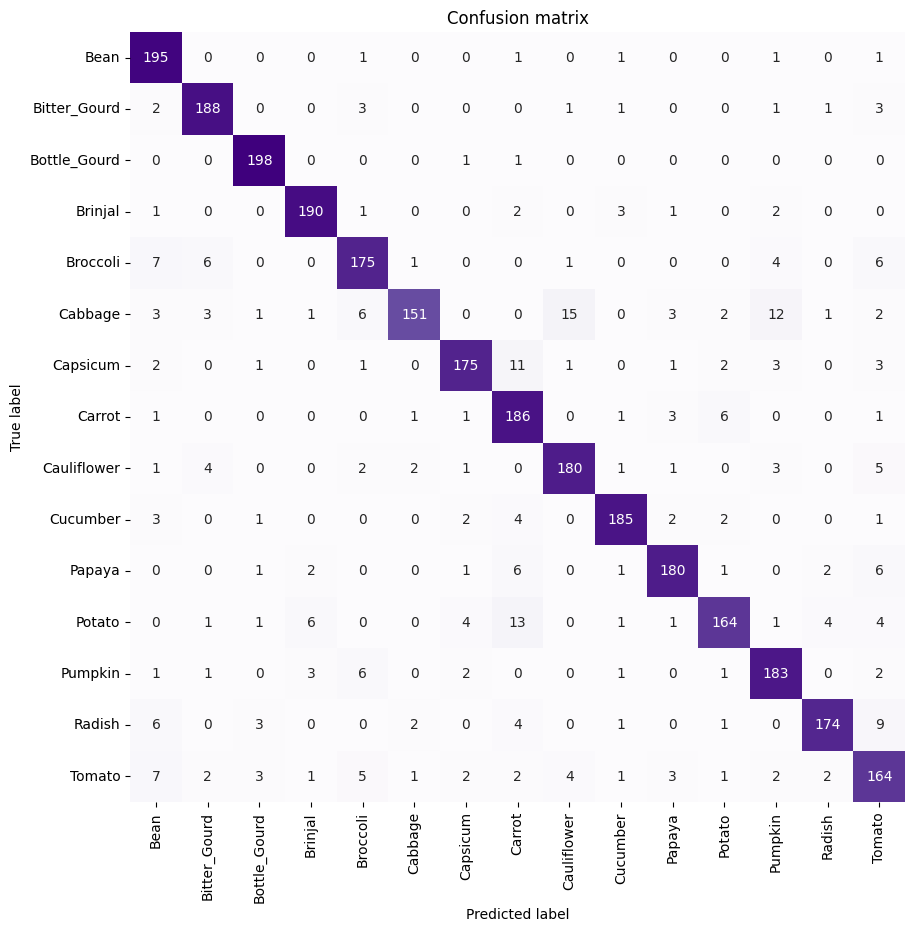

Classification Report:
               precision    recall  f1-score   support

        Bean       0.85      0.97      0.91       200
Bitter_Gourd       0.92      0.94      0.93       200
Bottle_Gourd       0.95      0.99      0.97       200
     Brinjal       0.94      0.95      0.94       200
    Broccoli       0.88      0.88      0.88       200
     Cabbage       0.96      0.76      0.84       200
    Capsicum       0.93      0.88      0.90       200
      Carrot       0.81      0.93      0.87       200
 Cauliflower       0.89      0.90      0.90       200
    Cucumber       0.94      0.93      0.93       200
      Papaya       0.92      0.90      0.91       200
      Potato       0.91      0.82      0.86       200
     Pumpkin       0.86      0.92      0.89       200
      Radish       0.95      0.87      0.91       200
      Tomato       0.79      0.82      0.81       200

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
we

In [209]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying Dilated Convolution instead of MaxPooling2D

### Modelling

Explaination
- Dilated convolutions helps to expand the area of the input image covered without pooling. The objective is to cover more information about the image from the output obtained with every convolution operation.
- It increases receptive field without increasing parameters.
- It can capture features at multiple scales.
- It reduced spatial resolution loss compared to regular convolutions with larger filters.

Reference:
https://www.geeksforgeeks.org/dilated-convolution/

In [33]:
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), dilation_rate=(2, 2), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(3, 3))
model.add(Dropout(0.25))
model.add(Conv2D(128,(4, 4), dilation_rate=(2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), dilation_rate=(2, 2), activation='relu'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=15, batch_size=64, verbose=1) 

Epoch 1/15
142/142 [==============================] - 7s 42ms/step - loss: 2.5164 - accuracy: 0.1533 - val_loss: 2.4740 - val_accuracy: 0.1850
Epoch 2/15
142/142 [==============================] - 5s 38ms/step - loss: 2.0200 - accuracy: 0.3505 - val_loss: 2.7423 - val_accuracy: 0.1813
Epoch 3/15
142/142 [==============================] - 6s 40ms/step - loss: 1.7150 - accuracy: 0.4558 - val_loss: 1.8489 - val_accuracy: 0.4020
Epoch 4/15
142/142 [==============================] - 6s 39ms/step - loss: 1.2997 - accuracy: 0.5884 - val_loss: 1.3240 - val_accuracy: 0.5733
Epoch 5/15
142/142 [==============================] - 6s 41ms/step - loss: 0.9840 - accuracy: 0.6901 - val_loss: 1.2978 - val_accuracy: 0.6077
Epoch 6/15
142/142 [==============================] - 6s 41ms/step - loss: 0.7651 - accuracy: 0.7573 - val_loss: 1.7531 - val_accuracy: 0.5050
Epoch 7/15
142/142 [==============================] - 6s 40ms/step - loss: 0.6763 - accuracy: 0.7884 - val_loss: 0.9782 - val_accuracy: 0.7167

### Evaluation

In [34]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 125, 125, 128)     2176      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 41, 41, 128)      0         
 2D)                                                             
                                                                 
 dropout_21 (Dropout)        (None, 41, 41, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 35, 35, 128)       262272    
                                                                 
 dropout_22 (Dropout)        (None, 35, 35, 128)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 29, 29, 128)       262272    
                                                      

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.8839185237884521
Validation Accuracy: 0.8213333487510681


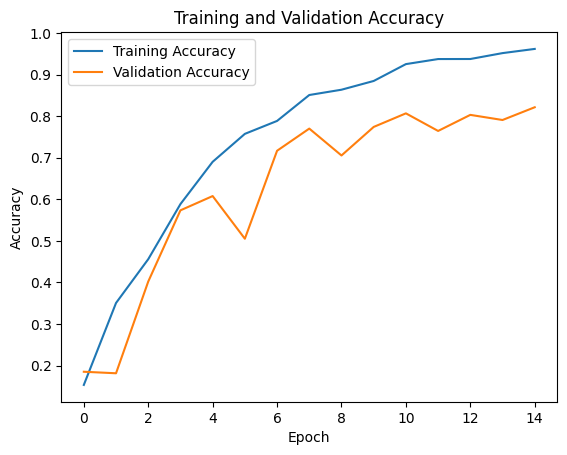

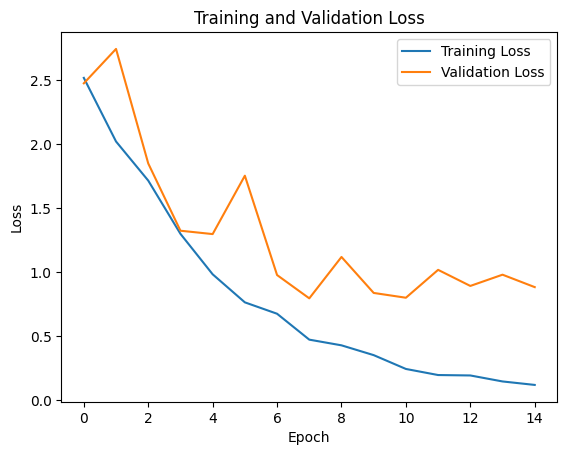

In [35]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 1s 6ms/step


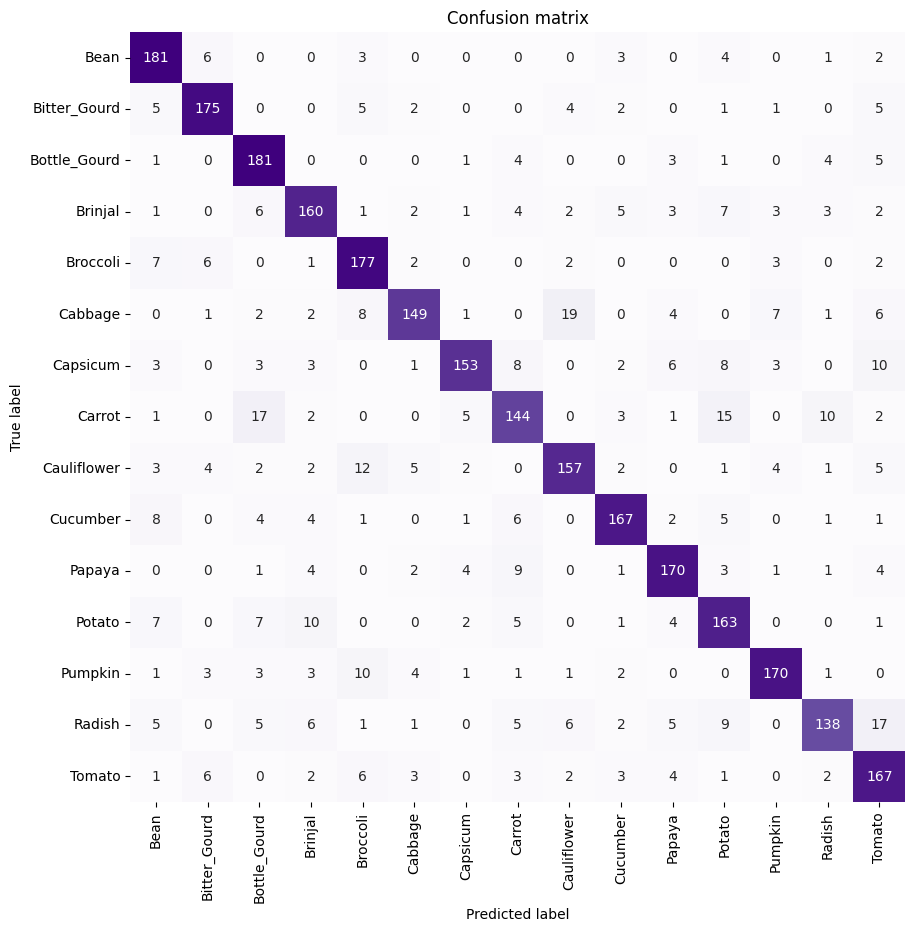

Classification Report:
               precision    recall  f1-score   support

        Bean       0.81      0.91      0.85       200
Bitter_Gourd       0.87      0.88      0.87       200
Bottle_Gourd       0.78      0.91      0.84       200
     Brinjal       0.80      0.80      0.80       200
    Broccoli       0.79      0.89      0.83       200
     Cabbage       0.87      0.74      0.80       200
    Capsicum       0.89      0.77      0.82       200
      Carrot       0.76      0.72      0.74       200
 Cauliflower       0.81      0.79      0.80       200
    Cucumber       0.87      0.83      0.85       200
      Papaya       0.84      0.85      0.85       200
      Potato       0.75      0.81      0.78       200
     Pumpkin       0.89      0.85      0.87       200
      Radish       0.85      0.69      0.76       200
      Tomato       0.73      0.83      0.78       200

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
we

In [36]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying Strided Convolution instead of MaxPooling2D

### Modelling

Explanation
- By a larger stride, the number of convolutions can be reduced. It helps to reduce the computational requirements.
- Therefore it can help control the level of abstraction at which the CNN learns feactures

Reference: https://www.naukri.com/code360/library/stride-in-convolutional-neural-network

In [15]:
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), strides=(3, 3), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (4, 4), strides=(3, 3), activation='relu'))
model.add(Conv2D(128, (4, 4), strides=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=30, batch_size=64, verbose=1) 

Epoch 1/30
142/142 [==============================] - 2s 10ms/step - loss: 2.5104 - accuracy: 0.1605 - val_loss: 2.3931 - val_accuracy: 0.1993
Epoch 2/30
142/142 [==============================] - 1s 9ms/step - loss: 2.1085 - accuracy: 0.3113 - val_loss: 2.1222 - val_accuracy: 0.3047
Epoch 3/30
142/142 [==============================] - 1s 9ms/step - loss: 1.8390 - accuracy: 0.3948 - val_loss: 1.8351 - val_accuracy: 0.3913
Epoch 4/30
142/142 [==============================] - 1s 8ms/step - loss: 1.6210 - accuracy: 0.4777 - val_loss: 1.6813 - val_accuracy: 0.4440
Epoch 5/30
142/142 [==============================] - 1s 9ms/step - loss: 1.4384 - accuracy: 0.5373 - val_loss: 1.4370 - val_accuracy: 0.5320
Epoch 6/30
142/142 [==============================] - 1s 8ms/step - loss: 1.2671 - accuracy: 0.5892 - val_loss: 1.7513 - val_accuracy: 0.4227
Epoch 7/30
142/142 [==============================] - 1s 9ms/step - loss: 1.1564 - accuracy: 0.6278 - val_loss: 1.4270 - val_accuracy: 0.5313
Epoch

### Evaluation

In [16]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 43, 43, 128)       2176      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 6, 6, 128)         262272    
                                                                 
 conv2d_8 (Conv2D)           (None, 1, 1, 128)         262272    
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 1.115553379058838
Validation Accuracy: 0.7683333158493042


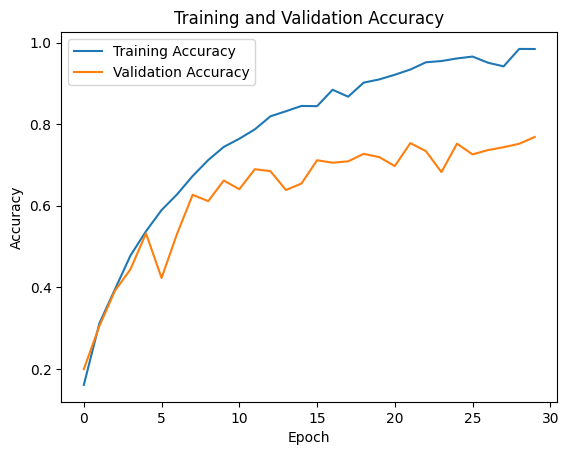

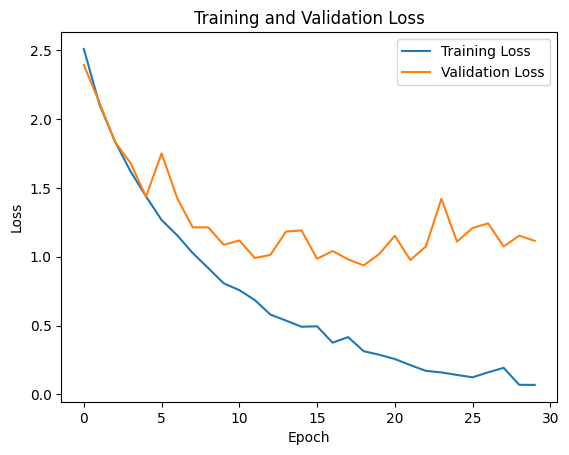

In [19]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 2ms/step


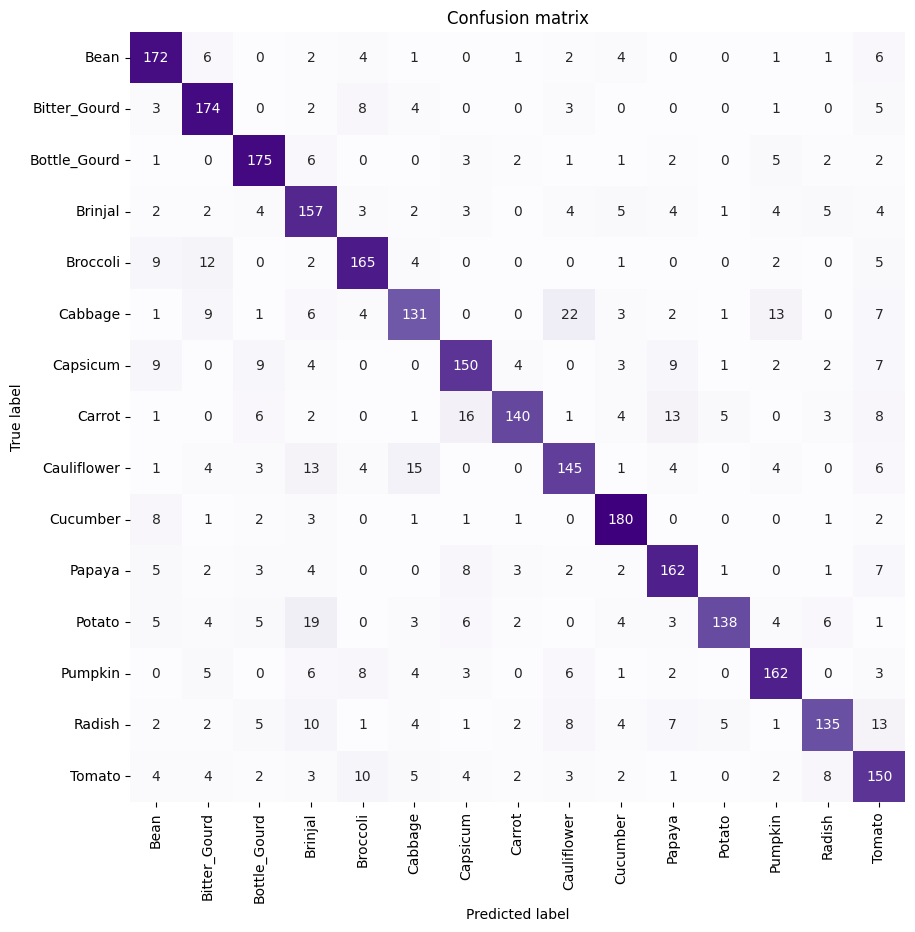

Classification Report:
               precision    recall  f1-score   support

        Bean       0.77      0.86      0.81       200
Bitter_Gourd       0.77      0.87      0.82       200
Bottle_Gourd       0.81      0.88      0.84       200
     Brinjal       0.66      0.79      0.72       200
    Broccoli       0.80      0.82      0.81       200
     Cabbage       0.75      0.66      0.70       200
    Capsicum       0.77      0.75      0.76       200
      Carrot       0.89      0.70      0.78       200
 Cauliflower       0.74      0.72      0.73       200
    Cucumber       0.84      0.90      0.87       200
      Papaya       0.78      0.81      0.79       200
      Potato       0.91      0.69      0.78       200
     Pumpkin       0.81      0.81      0.81       200
      Radish       0.82      0.68      0.74       200
      Tomato       0.66      0.75      0.70       200

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
we

In [20]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Trying GlobalAveragePooling2D instead of Flatten

### Modelling

Explanation
- Global Pooling condenses all of the feature maps into a single one, pooling all of the relevant information into a single map that can be easily understood by a single dense classification layer instead of multiple layers.
- I tried both GlobalAveragePooling2D and GlobalMaxPooling2D which both gave the same test accuracy.

Why should i not use Flatten
- When flattening, the network has to learn from oddly-shaped vectors in a very inefficient manner.

Reference: https://stackabuse.com/dont-use-flatten-global-pooling-for-cnns-with-tensorflow-and-keras/

In [238]:
from keras.layers import GlobalMaxPooling2D

# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(GlobalMaxPooling2D())
model.add(Dense(64, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=15, batch_size=64, verbose=1) 

Epoch 1/15
142/142 [==============================] - 5s 29ms/step - loss: 2.4604 - accuracy: 0.1756 - val_loss: 2.3722 - val_accuracy: 0.2260
Epoch 2/15
142/142 [==============================] - 4s 27ms/step - loss: 1.7983 - accuracy: 0.4270 - val_loss: 1.7679 - val_accuracy: 0.4207
Epoch 3/15
142/142 [==============================] - 4s 27ms/step - loss: 1.3326 - accuracy: 0.5737 - val_loss: 1.2169 - val_accuracy: 0.6300
Epoch 4/15
142/142 [==============================] - 4s 28ms/step - loss: 1.0262 - accuracy: 0.6724 - val_loss: 1.0691 - val_accuracy: 0.6550
Epoch 5/15
142/142 [==============================] - 4s 27ms/step - loss: 0.8594 - accuracy: 0.7303 - val_loss: 0.9502 - val_accuracy: 0.7040
Epoch 6/15
142/142 [==============================] - 4s 27ms/step - loss: 0.7729 - accuracy: 0.7496 - val_loss: 0.7402 - val_accuracy: 0.7850
Epoch 7/15
142/142 [==============================] - 4s 28ms/step - loss: 0.6365 - accuracy: 0.7977 - val_loss: 0.6643 - val_accuracy: 0.7937

### Evaluation

In [239]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_387 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 max_pooling2d_165 (MaxPooli  (None, 42, 42, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_312 (Dropout)       (None, 42, 42, 128)       0         
                                                                 
 conv2d_388 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 max_pooling2d_166 (MaxPooli  (None, 13, 13, 128)      0         
 ng2D)                                                           
                                                                 
 dropout_313 (Dropout)       (None, 13, 13, 128)    

### Model Analysis

#### Val loss & Val Acc

Validation Loss: 0.4988566040992737
Validation Accuracy: 0.8560000061988831


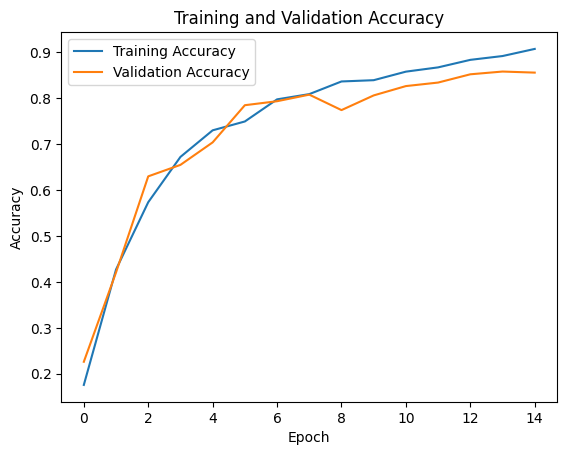

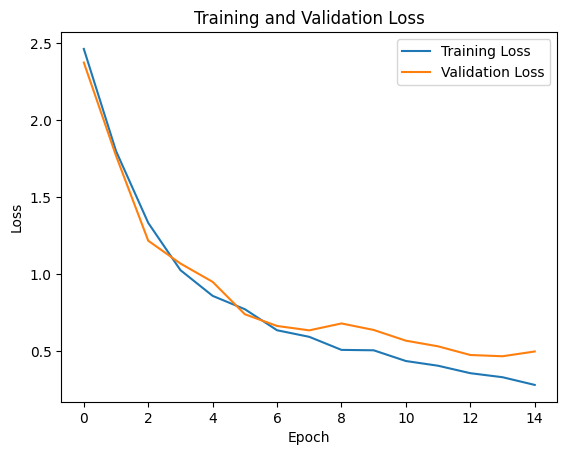

In [240]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#### Confusion Matrix

94/94 [==============================] - 0s 4ms/step


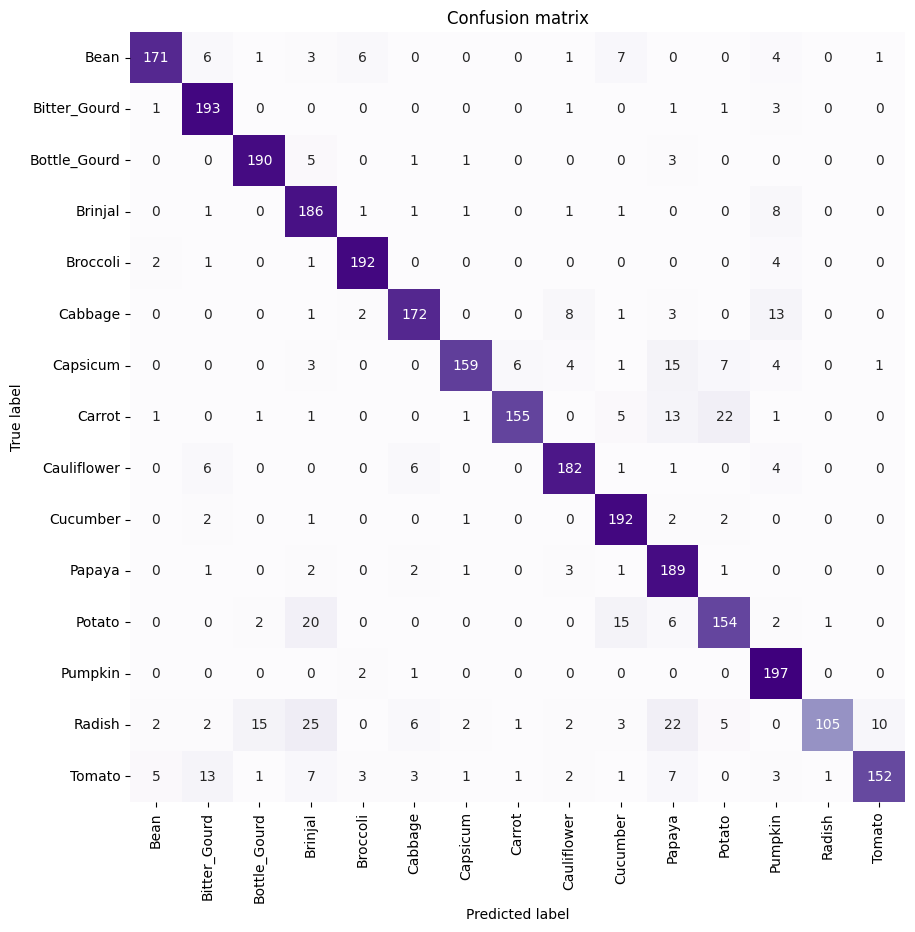

Classification Report:
               precision    recall  f1-score   support

        Bean       0.94      0.85      0.90       200
Bitter_Gourd       0.86      0.96      0.91       200
Bottle_Gourd       0.90      0.95      0.93       200
     Brinjal       0.73      0.93      0.82       200
    Broccoli       0.93      0.96      0.95       200
     Cabbage       0.90      0.86      0.88       200
    Capsicum       0.95      0.80      0.87       200
      Carrot       0.95      0.78      0.85       200
 Cauliflower       0.89      0.91      0.90       200
    Cucumber       0.84      0.96      0.90       200
      Papaya       0.72      0.94      0.82       200
      Potato       0.80      0.77      0.79       200
     Pumpkin       0.81      0.98      0.89       200
      Radish       0.98      0.53      0.68       200
      Tomato       0.93      0.76      0.84       200

    accuracy                           0.86      3000
   macro avg       0.88      0.86      0.86      3000
we

In [241]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

# **Improving CNN Model**

## RandomSearchCV + Stratified Kfold

RandomSearchCV Explanation
- RandomSearchCV requires fewer iterations than GridSearchCv as it samples a fixed number of parameter settings, hence its more efficient in the context of Deep Learning neural networks.
- It provides a more diverse exploration of hyperparameter space which is beneficial for finding good hyperparameter configurations.
- RandomizedSearchCV is preferred for efficiency, scalability, and exploration of the hyperparameter space.

Stratified Kfold Explanation
- StratifiedKflod ensures that each fold preserves the percentage of samples for each lables this making it a balanced class distribution.
- It improves generalization to unseen data as they are trained on a more diverse set of samples.
- StratifiedKFold is preferred for maintaining balanced class distribution, improving representativeness, and enhancing generalization of models, particularly in the context of imbalanced datasets.

Reference:
1. https://www.linkedin.com/pulse/model-optimization-machine-learning-random-vs-neves-junior-phd-x459f/
2. https://www.kaggle.com/discussions/general/231173

### Initialize

In [6]:
# Define hyperparameters
param_dist = {
    'conv_layers': [2, 3, 4],
    'filter_size': [32, 64, 128],
    'kernel_size': [(5, 5), (4, 4)],
    'stride_size': [(2, 2), (1, 1)], 
    'dense_layers': [1, 2, 3],
    'dropout_rate': [0.25, 0.3], 
    'epochs': [15],
    'batch_size': [32, 64]
}

# Define the CNN model
def create_cnn_model(conv_layers, filter_size, kernel_size, stride_size, dense_layers, dropout_rate):
    model = Sequential()

    # Input layer
    model.add(Conv2D(filter_size, kernel_size, input_shape=(131, 131, 1), strides=stride_size, activation='relu'))
    model.add(MaxPooling2D(2,2))
    
    # Hidden layers
    for _ in range(conv_layers):
        filter_size *= 2
        model.add(Conv2D(filter_size, kernel_size, strides=stride_size, activation='relu'))

    # Flatten
    model.add(Flatten())

    # Dense layer
    for _ in range(dense_layers):
        model.add(Dense(filter_size, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize stratified k-fold cross-validator
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the CNN model
model = KerasClassifier(build_fn=create_cnn_model)

# Initialize and fit the RandomizedSearchCV
randomCV = RandomizedSearchCV(estimator=model, param_distributions=param_dist, cv=stratified_kfold, verbose=2, n_iter=10, random_state=42)
randomCV_results = randomCV.fit(X_train, y_train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END batch_size=64, conv_layers=4, dense_layers=3, dropout_rate=0.3, epochs=15, filter_size=64, kernel_size=(5, 5), stride_size=(2, 2); total time=   1.6s
[CV] END batch_size=64, conv_layers=4, dense_layers=3, dropout_rate=0.3, epochs=15, filter_size=64, kernel_size=(5, 5), stride_size=(2, 2); total time=   0.1s
[CV] END batch_size=64, conv_layers=4, dense_layers=3, dropout_rate=0.3, epochs=15, filter_size=64, kernel_size=(5, 5), stride_size=(2, 2); total time=   0.1s
[CV] END batch_size=64, conv_layers=4, dense_layers=3, dropout_rate=0.3, epochs=15, filter_size=64, kernel_size=(5, 5), stride_size=(2, 2); total time=   0.1s
[CV] END batch_size=64, conv_layers=4, dense_layers=3, dropout_rate=0.3, epochs=15, filter_size=64, kernel_size=(5, 5), stride_size=(2, 2); total time=   0.1s
Epoch 1/15
226/226 [==============================] - 14s 38ms/step - loss: 2.6120 - accuracy: 0.1907
Epoch 2/15
226/226 [======================

### Evaluation on test

In [7]:
# Print the best parameters and corresponding accuracy
print("Best Parameters:", randomCV.best_params_)
print("Best Accuracy:", randomCV.best_score_)

# Get the best model
best_model = randomCV_results.best_estimator_.model

# Evaluate the best model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Best Parameters: {'stride_size': (2, 2), 'kernel_size': (4, 4), 'filter_size': 64, 'epochs': 15, 'dropout_rate': 0.25, 'dense_layers': 2, 'conv_layers': 2, 'batch_size': 32}
Best Accuracy: 0.836949598789215
94/94 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.8473
Test Accuracy: 84.73%


### Use best parameters and create the model

In [8]:
# Best params
best_params = randomCV_results.best_params_

# Create model using similar function as the randomCV
def create_best_cnn_model():
    model = Sequential()

    # Input layer
    model.add(Conv2D(best_params['filter_size'], best_params['kernel_size'], input_shape=(131, 131, 1), strides=best_params['stride_size'], activation='relu'))
    model.add(MaxPooling2D(3,3))
    
    # Hidden layers
    for _ in range(best_params['conv_layers']):
        best_params['filter_size'] *= 2
        model.add(Conv2D(best_params['filter_size'], best_params['kernel_size'], strides=best_params['stride_size'], activation='relu'))

    # Flatten
    model.add(Flatten())

    # Dense layer
    for _ in range(best_params['dense_layers']):
        model.add(Dense(best_params['filter_size'], activation='relu'))
        model.add(Dropout(best_params['dropout_rate']))

    # Output layer
    model.add(Dense(15, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Call the create best CNN model function
best_model = create_best_cnn_model()

history = best_model.fit(X_train, y_train, 
                         batch_size=best_params['batch_size'], 
                         epochs=best_params['epochs'], 
                         validation_data=(X_validation, y_validation))

# View the layer summary
best_model.summary()

# Final evaluation of the model 
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Epoch 1/15
283/283 [==============================] - 3s 9ms/step - loss: 2.3761 - accuracy: 0.1859 - val_loss: 2.0771 - val_accuracy: 0.3143
Epoch 2/15
283/283 [==============================] - 2s 7ms/step - loss: 1.7617 - accuracy: 0.4258 - val_loss: 1.5248 - val_accuracy: 0.4690
Epoch 3/15
283/283 [==============================] - 2s 8ms/step - loss: 1.3609 - accuracy: 0.5537 - val_loss: 1.5271 - val_accuracy: 0.5013
Epoch 4/15
283/283 [==============================] - 2s 8ms/step - loss: 1.1071 - accuracy: 0.6402 - val_loss: 1.0112 - val_accuracy: 0.6817
Epoch 5/15
283/283 [==============================] - 2s 8ms/step - loss: 0.8388 - accuracy: 0.7321 - val_loss: 0.8810 - val_accuracy: 0.7127
Epoch 6/15
283/283 [==============================] - 2s 8ms/step - loss: 0.7117 - accuracy: 0.7714 - val_loss: 1.1216 - val_accuracy: 0.6537
Epoch 7/15
283/283 [==============================] - 2s 8ms/step - loss: 0.5709 - accuracy: 0.8181 - val_loss: 0.6126 - val_accuracy: 0.8057
Epoch 

## Finding the best Activation Function and Optimizer

Activation Function Explanation
- ReLU (Rectified Linear Unit) helps the  model learn complex patterns by allowing it to model non-linear relationships between the features.
- Tanh (Hyperbolic Tangent) is used in binary classification tasks and provides outputs in a symmetrical range around zero.
- Leaky ReLU is a variant of ReLU and it helps to increase the range of the ReLU function.

Optimizer Explanation
- Adam (Adaptive Moment Estimation) adapts the learning rate during training and keeps an exponentially decaying average of past gradients.
- RMSprop (Root Mean Square Propagation) divides the learning rate by the root of this moving average, which helps to normalize the updates and improve convergence.
- SGD (Stochastic Gradient Descent) updates the parameters of the model in the direction of the negative gradient of the loss function with respect to the parameters.

References
1. https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
2. https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

In [ ]:
# list of activation functions to test
activation_functions = ['relu', 'tanh', LeakyReLU(alpha=0.1)]
optimizers = ['adam', 'rmsprop', 'sgd']

# Store the results
results = {}

for activation_func in activation_functions:
    for optimizer_name in optimizers:
        # Create model 
        model = Sequential() 
        model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation=activation_func))
        model.add(MaxPooling2D(pool_size=(3, 3))) 
        model.add(Dropout(0.5))
        model.add(Conv2D(128, (4, 4), activation=activation_func))
        model.add(MaxPooling2D(pool_size=(3, 3))) 
        model.add(Dropout(0.25))
        model.add(Conv2D(128, (4, 4), activation=activation_func))
        model.add(MaxPooling2D(pool_size=(3, 3)))  
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(64, activation=activation_func)) 
        model.add(Dense(num_classes, activation='softmax')) 
    
        # Compile the model
        model.compile(loss='categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])
    
        # Train the model
        history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                            epochs=15, batch_size=64, verbose=1)

        # Evaluate the model
        test_loss, test_acc = model.evaluate(X_test, y_test)

        # Store the results
        results[(activation_func, optimizer_name)] = test_acc

# Sort the results dictionary based on test accuracy
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

In [118]:
# Print the best accuracy
best_activation_func, best_optimizer, best_accuracy = sorted_results[0][0][0], sorted_results[0][0][1], sorted_results[0][1]
print(f"Best Accuracy: {best_accuracy*100:.2f}%\nActivation Function: {best_activation_func}\nOptimizer: {best_optimizer}")

Best Accuracy: 93.53%
Activation Function: <keras.layers.activation.leaky_relu.LeakyReLU object at 0x000002211FBB8C70>
Optimizer: adam


## Transfer Learning

### Convert grayscale to rgb

In [45]:
# Images needs to have 3 channels
def grayscale_to_rgb(grayscale_images):

    # 
    num_images, height, width = grayscale_images.shape
    
    # Convert to 3D array by replicating grayscale across RGB
    rgb_images = np.repeat(grayscale_images[..., np.newaxis], 3, axis=-1)
    
    return rgb_images

# Convert the datasets
X_train_rgb = grayscale_to_rgb(X_train)
X_validation_rgb = grayscale_to_rgb(X_validation)
X_test_rgb = grayscale_to_rgb(X_test)

### VGG16

Explanation
- VGG16 is a pre=trained deep learning model that has been used for image classification
- It is able to extract high-level and complex features from the input images which allows it to capture more complex patterns and relationships between the input features therefore leading to improved performance.
- It is effective due to its simplicity, availability, transfer learning capabilities, compatibility, and competitive performance.

Reference: https://medium.com/@jaeheonk817/concept-vgg16-power-of-transfer-learning-on-image-classification-a9c0b3ee27f8

In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Find number of labels
num_classes = len(np.unique(y_train_labels))

# Load pre-trained VGG16 model (excluding top layers) with weights trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(131, 131, 3))

# Freeze convolutional layers
base_model.trainable = False

# Create model
model = Sequential() 
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu')) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001)

# Fine-tune the model on your dataset
history = model.fit(X_train_rgb, y_train, validation_data=(X_validation_rgb, y_validation),
          epochs=15, batch_size=64, verbose=1, callbacks=[early_stopping]) 

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/15
142/142 [==============================] - 9s 53ms/step - loss: 1.4877 - accuracy: 0.6004 - val_loss: 0.9924 - val_accuracy: 0.7213
Epoch 2/15
142/142 [==============================] - 6s 39ms/step - loss: 0.6943 - accuracy: 0.8211 - val_loss: 0.6529 - val_accuracy: 0.8220
Epoch 3/15
142/142 [==============================] - 6s 39ms/step - loss: 0.4838 - accuracy: 0.8747 - val_loss: 0.4881 - val_accuracy: 0.8670
Epoch 4/15
142/142 [==============================] - 6s 39ms/step - loss: 0.3690 - accuracy: 0.9072 - val_loss: 0.4218 - val_accuracy: 0.8803
Epoch 5/15
142/142 [==============================] - 6s 40ms/step - loss: 0.3011 - accuracy: 0.9263 - val_loss: 0.3400 - val_accuracy: 0.9107
Epoch 6/15
142/142 [==============================] - 6s 40ms/step - loss: 0.2517 - accuracy: 0.9376 - val_loss: 0.2870 - val_accuracy: 0.9273
Epoch 7/15
142/142 [==============================] - 6s 40ms/step - loss: 0.

#### Evaluation

In [47]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_202 (Dense)           (None, 256)               131328    
                                                                 
 dense_203 (Dense)           (None, 15)                3855      
                                                                 
Total params: 14,849,871
Trainable params: 135,183
Non-trainable params: 14,714,688
_________________________________________________________________
94/94 [==============================] - 3s 23ms/step - loss: 0.1507 - accuracy: 0.9580

Test accurac

### MobileNet

Explanation
- Mobilenets are designed to be efficient, meaning they can run on limited computational resources.
- It is also typically much faster than traditional convolutional neural networks.
- They are smaller sizes and only need a small memory footprint therefore they are easy to deploy and use.

Reference: https://medium.com/@nocodingai/mobilenet-fc34af9f58a5

In [48]:
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.layers import GlobalAveragePooling2D

# # Find number of labels
# num_classes = len(np.unique(y_train_labels))

# # Load pre-trained MobileNet model (excluding top layers) with weights trained on ImageNet
# base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(131, 131, 3)) 

# # Freeze convolutional layers
# base_model.trainable = False

# # Create model
# model = Sequential() 
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(256, activation='relu')) 
# model.add(Dense(num_classes, activation='softmax')) 

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001)

# # Fine-tune the model on your dataset
# history = model.fit(X_train_rgb, y_train, validation_data=(X_validation_rgb, y_validation),
#           epochs=15, batch_size=64, verbose=1, callbacks=[early_stopping]) 

17225924/17225924 [==============================] - 2s 0us/step
Epoch 1/15
142/142 [==============================] - 5s 23ms/step - loss: 0.2851 - accuracy: 0.9136 - val_loss: 0.0687 - val_accuracy: 0.9793
Epoch 2/15
142/142 [==============================] - 3s 18ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0429 - val_accuracy: 0.9860
Epoch 3/15
142/142 [==============================] - 3s 18ms/step - loss: 0.0064 - accuracy: 0.9996 - val_loss: 0.0362 - val_accuracy: 0.9897
Epoch 4/15
142/142 [==============================] - 3s 18ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0301 - val_accuracy: 0.9900
Epoch 5/15
142/142 [==============================] - 3s 18ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0295 - val_accuracy: 0.9897
Epoch 6/15
142/142 [==============================] - 3s 18ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0272 - val_accuracy: 0.9903
Epoch 7/15
142/142 [==============================] - 3s 18ms/step - loss: 8.

#### Evaluation

In [49]:
# # View the layer summary
# model.summary()

# # Final evaluation of the model 
# test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
# print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_204 (Dense)           (None, 256)               262400    
                                                                 
 dense_205 (Dense)           (None, 15)                3855      
                                                                 
Total params: 3,495,119
Trainable params: 266,255
Non-trainable params: 3,228,864
_________________________________________________________________
94/94 [==============================

# **Final Model**

## Modelling

- From the CNN model's I found out that the best CNN model is using Convo2D, MaxPooling2D, Dropout
- Using RandomSearchCV and Stratified Kfold, I found the best parameters
- Using a loop function, I found the best Activation Function ('Leaky ReLU') and Optimizer ('Adam')

In [31]:
# Get the number of unique labels
num_classes = len(np.unique(y_train_labels))

# Create model 
model = Sequential() 
model.add(Conv2D(128, (4, 4), input_shape=(131, 131, 1), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(3, 3))) 
model.add(Dropout(0.25))
model.add(Conv2D(128, (4, 4), activation=LeakyReLU(alpha=0.1)))
model.add(MaxPooling2D(pool_size=(3, 3)))  
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation=LeakyReLU(alpha=0.1))) 
model.add(Dropout(0.25))
model.add(Dense(64, activation=LeakyReLU(alpha=0.1))) 
model.add(Dense(num_classes, activation='softmax')) 

# Compile model 
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])  

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.001)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(filepath='best_model_131.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          epochs=30, batch_size=64, verbose=1, callbacks=[early_stopping, model_checkpoint]) 

Epoch 1/30
142/142 [==============================] - 6s 36ms/step - loss: 2.4178 - accuracy: 0.1606 - val_loss: 2.3056 - val_accuracy: 0.2463
Epoch 2/30
142/142 [==============================] - 5s 34ms/step - loss: 1.8877 - accuracy: 0.3721 - val_loss: 1.5022 - val_accuracy: 0.5057
Epoch 3/30
142/142 [==============================] - 5s 34ms/step - loss: 1.2814 - accuracy: 0.5825 - val_loss: 1.0579 - val_accuracy: 0.6463
Epoch 4/30
142/142 [==============================] - 5s 33ms/step - loss: 0.9638 - accuracy: 0.6895 - val_loss: 1.0442 - val_accuracy: 0.6543
Epoch 5/30
142/142 [==============================] - 5s 34ms/step - loss: 0.7349 - accuracy: 0.7607 - val_loss: 0.8077 - val_accuracy: 0.7267
Epoch 6/30
142/142 [==============================] - 5s 34ms/step - loss: 0.6767 - accuracy: 0.7815 - val_loss: 0.7558 - val_accuracy: 0.7483
Epoch 7/30
142/142 [==============================] - 5s 34ms/step - loss: 0.5042 - accuracy: 0.8353 - val_loss: 0.5864 - val_accuracy: 0.8120

## Evaluation

In [32]:
# View the layer summary
model.summary()

# Final evaluation of the model 
test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy:', f'{test_acc*100:.2f}%')

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_249 (Conv2D)         (None, 128, 128, 128)     2176      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 42, 42, 128)      0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 42, 42, 128)       0         
                                                                 
 conv2d_250 (Conv2D)         (None, 39, 39, 128)       262272    
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 13, 13, 128)      0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 13, 13, 128)     

## Model Analysis

### Val loss & Val Acc

Validation Loss: 0.26993057131767273
Validation Accuracy: 0.9223333597183228


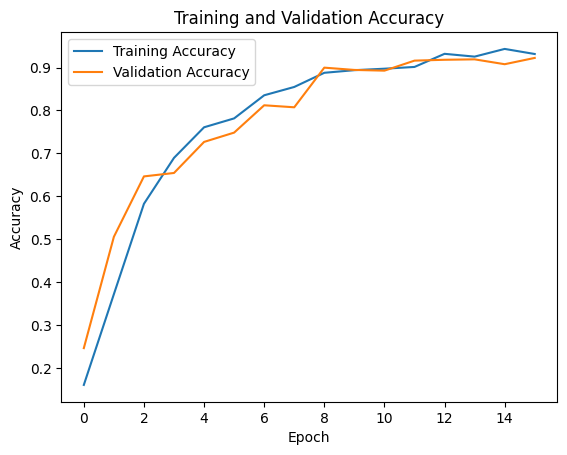

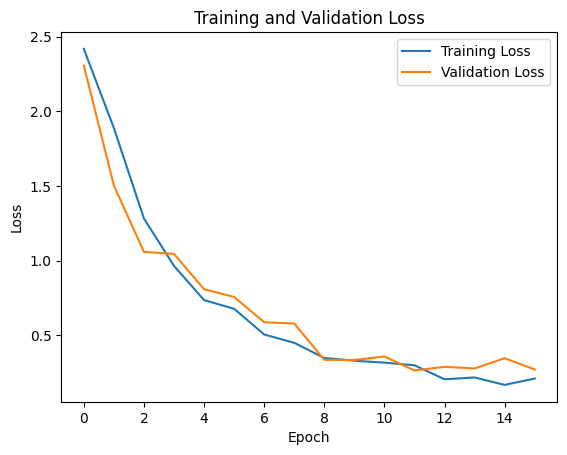

In [33]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_validation, y_validation, verbose=0)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Confusion Matrix

94/94 [==============================] - 1s 5ms/step


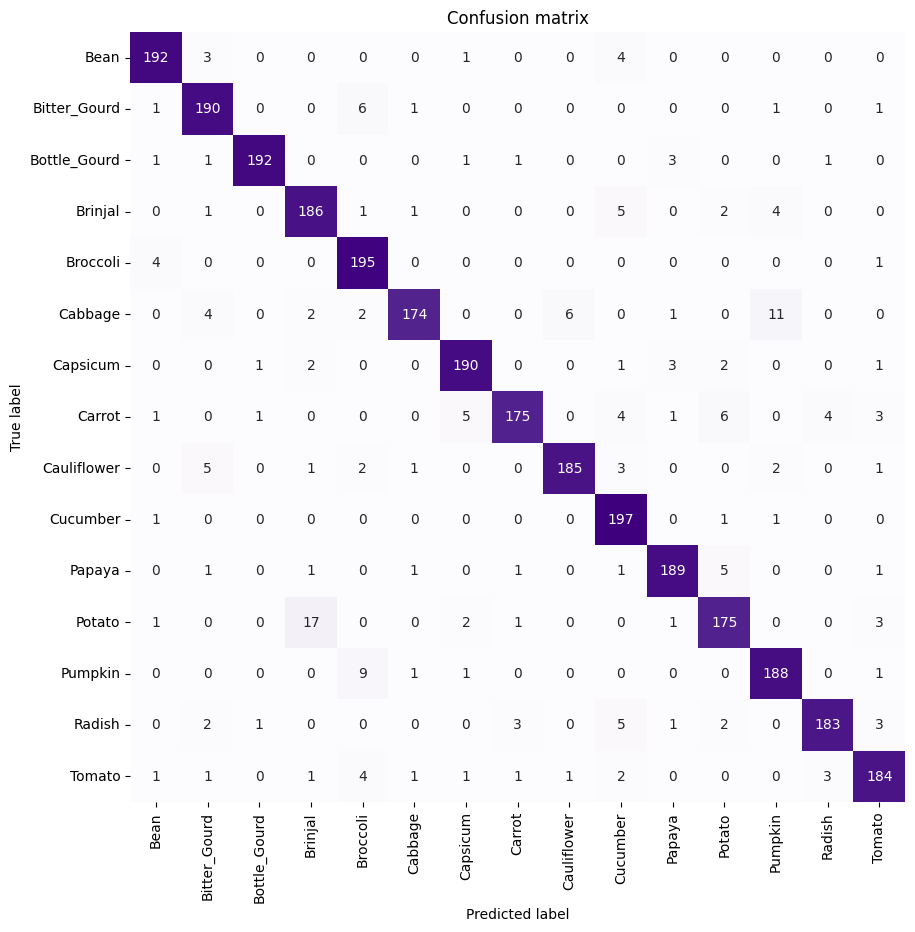

Classification Report:
               precision    recall  f1-score   support

        Bean       0.95      0.96      0.96       200
Bitter_Gourd       0.91      0.95      0.93       200
Bottle_Gourd       0.98      0.96      0.97       200
     Brinjal       0.89      0.93      0.91       200
    Broccoli       0.89      0.97      0.93       200
     Cabbage       0.97      0.87      0.92       200
    Capsicum       0.95      0.95      0.95       200
      Carrot       0.96      0.88      0.92       200
 Cauliflower       0.96      0.93      0.94       200
    Cucumber       0.89      0.98      0.93       200
      Papaya       0.95      0.94      0.95       200
      Potato       0.91      0.88      0.89       200
     Pumpkin       0.91      0.94      0.92       200
      Radish       0.96      0.92      0.94       200
      Tomato       0.92      0.92      0.92       200

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
we

In [39]:
# Get the class names
label_names = encoder.classes_

# Calculate predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Plot confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False,
           xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion matrix')
tick_marks = np.arange(num_classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))

## Load Model

In [37]:
from keras.models import load_model

# Load the saved model
model = load_model('best_model_131.h5')

# Compile the model (if needed)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# Evaluate the model on test data (if available)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print(f'Test accuracy:', f'{test_acc*100:.2f}%')

94/94 [==============================] - 1s 7ms/step - loss: 0.2395 - accuracy: 0.9317
Test Loss: 0.23953641951084137
Test accuracy: 93.17%
